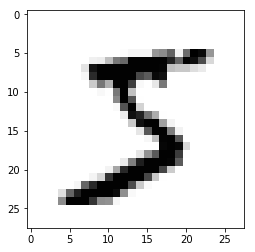

In [17]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [3]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [4]:
print(X_val.shape, y_train.shape)

(10000, 28, 28) (50000,)


In [5]:
X_train_new = X_train.reshape([50000, 784])
X_val_new = X_val.reshape([10000, 784])
X_test_new = X_test.reshape([10000, 784])

In [6]:
enc = OneHotEncoder()
enc.fit(np.reshape(y_train,(-1,1)))
y_train_new = enc.transform(np.reshape(y_train,(-1,1))).toarray()
y_val_new = enc.transform(np.reshape(y_val,(-1,1))).toarray()
y_test_new = enc.transform(np.reshape(y_test,(-1,1))).toarray()

Number of features and number of classes

In [7]:
features = X_train.shape[1]*X_train.shape[2]
classes = y_train_new.shape[1]
hidden_neurons = 500
hidden_neurons1 = 200
hidden_neurons2 = 50

## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$

In [8]:
import tensorflow as tf
import numpy as np
import math
from tensorflow.python.framework import ops
s = tf.InteractiveSession()

## Make the model

In [9]:
x = tf.placeholder(tf.float32, shape=(None,features))
y = tf.placeholder(tf.float32, shape=(None,classes))
weight1 = tf.get_variable('weight1', [features, hidden_neurons], initializer=tf.contrib.layers.xavier_initializer())
bias1 = tf.get_variable("bias1",  [hidden_neurons], initializer=tf.zeros_initializer())
logits_hidden = tf.matmul(x,weight1)+bias1
# First hidden layer
x_hidden = tf.nn.relu(logits_hidden)
x_hidden = tf.nn.dropout(x_hidden, 0.85)
weight2 = tf.get_variable("weight2", [hidden_neurons, hidden_neurons1], initializer=tf.contrib.layers.xavier_initializer())
bias2 = tf.get_variable("bias2",  [hidden_neurons1], initializer=tf.zeros_initializer())
logits_hidden1 = tf.matmul(x_hidden,weight2)+bias2
# Second hidden layer
x_hidden1 = tf.nn.relu(logits_hidden1)
x_hidden1 = tf.nn.dropout(x_hidden1, 0.75)
weight3 = tf.get_variable("weight3", [hidden_neurons1, hidden_neurons2], initializer=tf.contrib.layers.xavier_initializer())
bias3 = tf.get_variable("bias3",  [hidden_neurons2], initializer=tf.zeros_initializer())
logits_hidden2 = tf.matmul(x_hidden1,weight3)+bias3
# Third hidden layer
x_hidden2 = tf.nn.relu(logits_hidden2)
x_hidden2 = tf.nn.dropout(x_hidden2, 0.75)
weight4 = tf.get_variable("weight4", [hidden_neurons2, classes], initializer=tf.contrib.layers.xavier_initializer())
bias4 = tf.get_variable("bias4",  [classes], initializer=tf.zeros_initializer())
logits_final = tf.matmul(x_hidden2,weight4)+bias4
## Use sigmoid to get result
prediction = tf.nn.sigmoid(logits_final)

## Cost Function
In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i\, | \, x_i,w))}\right] $$

In [10]:
def log_loss(prediction, y):
    logLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=prediction))
    return logLoss

## Mini-batch SGD

Stochastic gradient descent just takes a random example on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



In [15]:
cost =log_loss(prediction, y)
learning_rate0 = 0.08
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate0, global_step, 100, 0.9, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

## Train the Model

Test cost after 10 epochs is 1.6319909
Test cost after 20 epochs is 1.5827721
Test cost after 30 epochs is 1.5554891
Test cost after 40 epochs is 1.5405394
Test cost after 50 epochs is 1.530127
Test cost after 60 epochs is 1.522825
Test cost after 70 epochs is 1.5162258
Test cost after 80 epochs is 1.5120541
Test cost after 90 epochs is 1.50819
Test cost after 100 epochs is 1.5040087
Test cost after 110 epochs is 1.5018184
Test cost after 120 epochs is 1.4985702
Test cost after 130 epochs is 1.4965237
Test cost after 140 epochs is 1.4942617
Test cost after 150 epochs is 1.492088
Test cost after 160 epochs is 1.4904279
Test cost after 170 epochs is 1.4889512
Test cost after 180 epochs is 1.4874415
Test cost after 190 epochs is 1.486216
Test cost after 200 epochs is 1.4851686


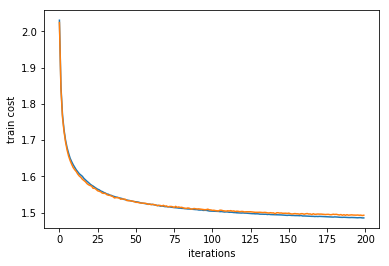

Train Accuracy is 0.97596
Test Accuracy is 0.9665


In [16]:
epoch = 200
batch = 500
iterations = list(range(epoch))
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    for j in range(epoch):
        for i in range(0, 50000, batch):
            sess.run(optimizer, feed_dict={x:X_train_new[i:i+batch], y:y_train_new[i: i+batch]})
        train_loss.append(sess.run(cost, feed_dict={x:X_train_new, y:y_train_new}))
        test_loss.append(sess.run(cost, feed_dict={x:X_test_new, y:y_test_new}))
        if j%10 == 9:
            print("Test cost after " + str(j+1)+ " epochs is "+ str(train_loss[-1]))
    plt.plot(iterations, train_loss, label='Train')
    plt.plot(iterations, test_loss, label='Test')
    plt.ylabel('train cost')
    plt.xlabel('iterations')
    plt.show()
    
    # Calculate the predictions
    predict_op = tf.argmax(logits_final, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({x: X_train_new, y: y_train_new})
    test_accuracy = accuracy.eval({x: X_test_new, y: y_test_new})
    print("Train Accuracy is", train_accuracy)
    print("Test Accuracy is", test_accuracy)